In [329]:
# %%  
# 0) Inline plots y librerías base
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dotenv import load_dotenv, find_dotenv

# Estilo rosa/morado
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (12,6),
    "axes.titlesize": 16,
    "axes.labelsize": 14
})
colors = ["#FF69B4", "#800080"]


In [330]:
# %%  
# 1) Configuración Gemini / fallback
try:
    import google.generativeai as genai
    from google.api_core.exceptions import InvalidArgument

    load_dotenv(find_dotenv(), override=True)
    genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
    GEMINI = genai.GenerativeModel("models/gemini-1.5-flash")

    def g_summary(prompt: str) -> str:
        try:
            return GEMINI.generate_content(
                prompt,
                generation_config={"temperature": 0.7, "max_output_tokens": 150}
            ).text
        except InvalidArgument:
            return "(fallback) " + prompt

except ImportError:
    def g_summary(prompt: str) -> str:
        return "(gemini no disponible) " + prompt



In [331]:
# %%  
# 2) Función para leer CSVs de una carpeta
def leer_archivos(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(".csv")]
    dfs=[]
    for f in archivos:
        dfs.append(pd.read_csv(os.path.join(carpeta,f), encoding="latin1"))
    return pd.concat(dfs, ignore_index=True)

# Ajusta esta ruta según tu sistema
ROOT = r"/Users/maria/Downloads/Desafio 4"

df22 = leer_archivos(os.path.join(ROOT, "2022"))
df23 = leer_archivos(os.path.join(ROOT, "2023"))
df   = pd.concat([df22, df23], ignore_index=True)

# Normalizar nombres de columna
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ","_")
)

In [332]:
# PARTE 2.1: analizar nulos 
df_nulos = df[df.isna().any(axis=1)]
print(df_nulos)
if 'año' in df.columns:
    print("Nulos en columna 'año':", df['año'].isna().sum())
    print("Filas donde 'año' es nulo:\n", df[df['año'].isna()])
else:
    print("⚠ La columna 'año' no existe después de limpiar los nombres. Revisa los nombres originales.")
print("Porcentaje de nulos por columna (%):")
print(df.isna().mean() * 100)

Empty DataFrame
Columns: [año, mes, id_cliente, tamaño_de_cliente, categoría, producto, venta_usd, venta_cajas]
Index: []
Nulos en columna 'año': 0
Filas donde 'año' es nulo:
 Empty DataFrame
Columns: [año, mes, id_cliente, tamaño_de_cliente, categoría, producto, venta_usd, venta_cajas]
Index: []
Porcentaje de nulos por columna (%):
año                  0.0
mes                  0.0
id_cliente           0.0
tamaño_de_cliente    0.0
categoría            0.0
producto             0.0
venta_usd            0.0
venta_cajas          0.0
dtype: float64


In [333]:
# %%  
# 3) Limpieza y construcción de fecha
MESES = ["Enero","Febrero","Marzo","Abril","Mayo","Junio",
         "Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]

# Limpia y categoriza
df["mes"] = df["mes"].astype(str).str.strip().str.capitalize()
df["mes"] = pd.Categorical(df["mes"], categories=MESES, ordered=True)

# Mapea a número 1–12 y crea fecha
mes_a_num = {m: i+1 for i,m in enumerate(MESES)}
df["mes_no"] = df["mes"].map(mes_a_num)
df["fecha"] = pd.to_datetime({
    "year":  df["año"].astype(int),
    "month": df["mes_no"].fillna(1).astype(int),
    "day":   1
}, errors="coerce")


In [334]:
# %%  
# 4) Resumen estadístico mensual por año
summary_monthly = (
    df
      .groupby(["año","mes_no"], observed=True)["venta_usd"]
      .agg(total="sum", promedio="mean", desviacion="std")
      .reset_index()
)
# Añade columna mes para mostrar
inv = {v:k for k,v in mes_a_num.items()}
summary_monthly["mes"] = summary_monthly["mes_no"].map(inv)
summary_monthly["mes"] = pd.Categorical(summary_monthly["mes"], categories=MESES, ordered=True)
summary_monthly = summary_monthly.sort_values(["año","mes_no"])

print(">> Resumen mensual por año:")
print(summary_monthly[["año","mes","total","promedio","desviacion"]].to_string(index=False))


>> Resumen mensual por año:
 año        mes       total  promedio  desviacion
2022      Enero 1679173.470 13.872537   53.067636
2022    Febrero 1745344.095 14.593422   40.538540
2022      Marzo 1611731.130 12.960622   35.047394
2022      Abril 1688750.085 13.378676   39.139402
2022       Mayo 1628590.710 13.390483   36.555911
2022      Junio 1439808.075 12.745725   27.836864
2022      Julio 1819997.610 14.608364   40.395673
2022     Agosto 1806540.225 15.090467   48.254988
2022 Septiembre 1759279.695 13.983401   43.071248
2022    Octubre 1774190.310 13.847555   42.241122
2022  Noviembre 1906934.700 14.971028   46.917728
2022  Diciembre 1989083.505 15.872289   54.908353
2023      Enero 1614919.455 13.385048   43.585303
2023    Febrero 1728858.900 14.602342   38.296891
2023      Marzo 1745221.080 12.942519   35.897368
2023      Abril 1556256.600 13.216617   34.933019
2023       Mayo 1837143.810 14.541959   37.075646
2023      Junio 1779173.445 14.198516   41.153366
2023      Julio 177715

Modelo: venta_usd = 11228.27·mes_acum + 1629000.25
RMSE: 114471.11, R²: 0.316


C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


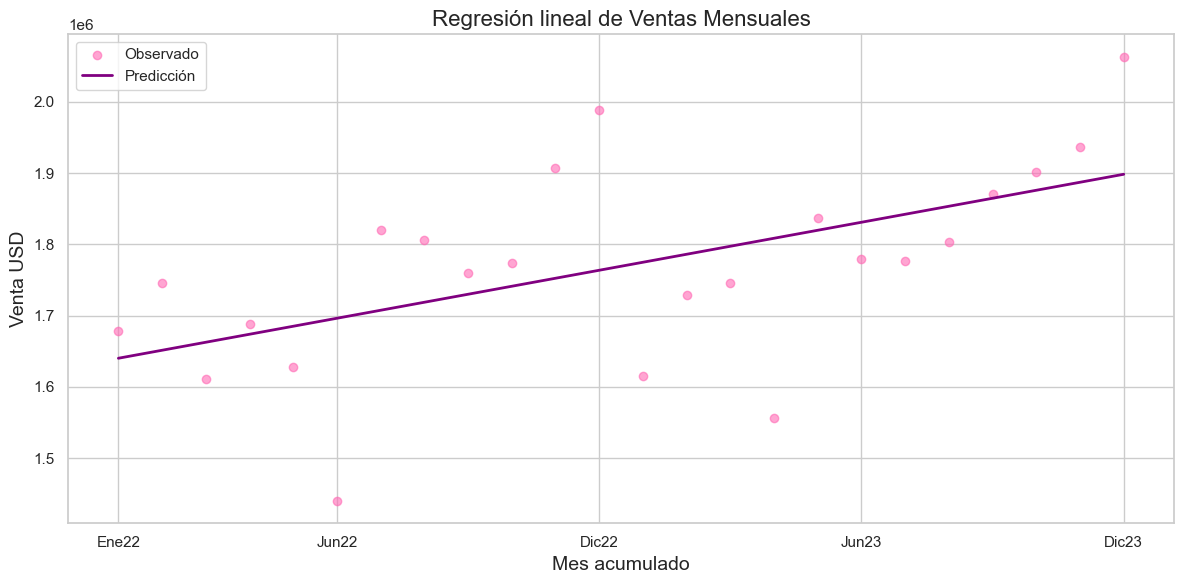

In [335]:
# %%  
# 6) Modelo Predictivo: Regresión lineal mensual
# • Usamos como variable predictora el índice de mes acumulado (1–24)
# • Y como objetivo la venta total mensual

# Asegúrate de que 'año' y 'mes_no' son numéricos
summary_monthly["año_num"]   = summary_monthly["año"].astype(int)
summary_monthly["mes_no"]    = summary_monthly["mes_no"].astype(int)

# Calcula mes acumulado
summary_monthly["mes_acum"]  = (summary_monthly["año_num"] - 2022) * 12 + summary_monthly["mes_no"]

# Define X y y
X = summary_monthly[["mes_acum"]]
y = summary_monthly["total"]

# Entrena el modelo
model = LinearRegression()
model.fit(X, y)

# Extrae coeficientes
a = model.coef_[0]
b = model.intercept_
print(f"Modelo: venta_usd = {a:.2f}·mes_acum + {b:.2f}")

# Evalúa
y_pred = model.predict(X)
rmse = mean_squared_error(y, y_pred, squared=False)
r2   = r2_score(y, y_pred)
print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Grafica
fig, ax = plt.subplots()
ax.scatter(X, y, color=colors[0], alpha=0.6, label="Observado")
ax.plot(X, y_pred, color=colors[1], linewidth=2, label="Predicción")
ax.set_xticks([1, 6, 12, 18, 24])
ax.set_xticklabels(["Ene22","Jun22","Dic22","Jun23","Dic23"])
ax.set_xlabel("Mes acumulado")
ax.set_ylabel("Venta USD")
ax.set_title("Regresión lineal de Ventas Mensuales")
ax.legend()
plt.tight_layout()
plt.show()


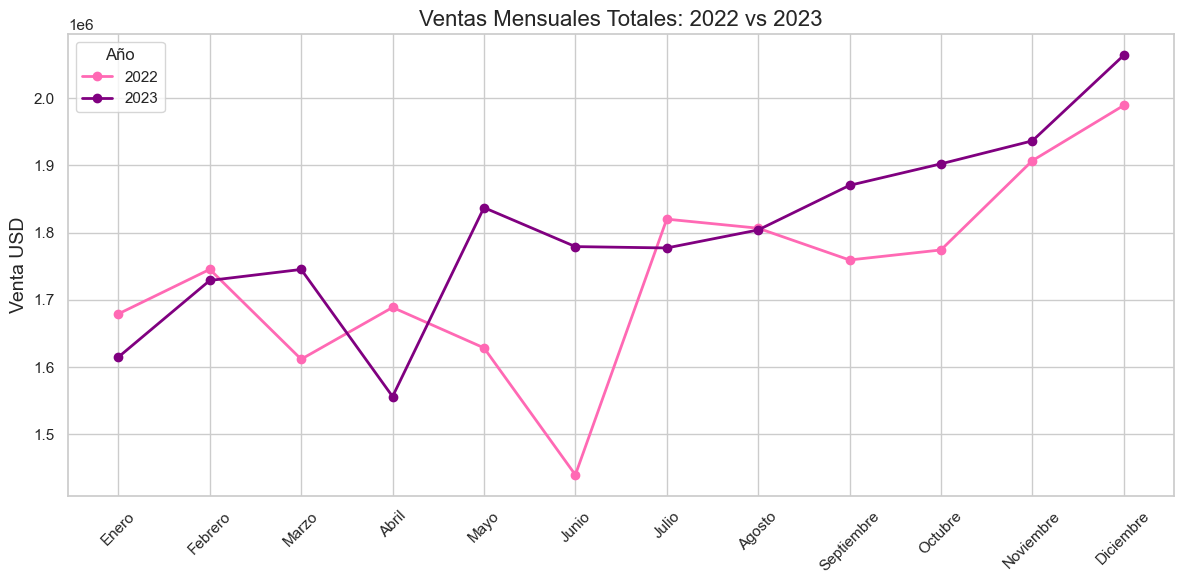

In [336]:
# %%
# 7) Ventas mensuales superpuestas 2022 vs 2023
pivot = summary_monthly.pivot(index="mes", columns="año", values="total").reindex(MESES)
pivot["mes_no"] = range(1,13)

fig, ax = plt.subplots()
for año,col in zip([2022,2023], colors):
    ax.plot(pivot["mes_no"], pivot[año], marker="o", lw=2, color=col, label=str(año))

ax.set_xticks(range(1,13))
ax.set_xticklabels(MESES, rotation=45)
ax.set_title("Ventas Mensuales Totales: 2022 vs 2023")
ax.set_ylabel("Venta USD")
ax.legend(title="Año")
plt.tight_layout()
plt.show()


In [337]:
# %%
# 7.2) Cross-selling pair (co-ocurrencia de cajas)
basket = df.pivot_table(index="id_cliente", columns="producto",
                        values="venta_cajas", aggfunc="sum", fill_value=0)
basket = (basket>0).astype(int)
cooc = basket.T.dot(basket)
for p in basket.columns: cooc.loc[p,p] = 0
mejor_pair = cooc.stack().idxmax()
print("Top cross-selling pair:", mejor_pair)

Top cross-selling pair: ('Coca-Cola 300 ml NR Pet 12B', 'Coca-Cola E 1Lt NR Pet 12B')


In [338]:
# %%  
# 8) ANOVA: ¿difieren significativamente las ventas mensuales entre 2022 y 2023?
from scipy.stats import f_oneway

# Extrae series de totales por año
ventas_2022 = summary_monthly.loc[summary_monthly['año']==2022, 'total']
ventas_2023 = summary_monthly.loc[summary_monthly['año']==2023, 'total']

F, p = f_oneway(ventas_2022, ventas_2023)
print(f"ANOVA 2022 vs 2023: F = {F:.3f}, p = {p:.3f}")
if p < 0.05:
    print("→ Rechazamos H0: hay diferencia significativa de medias.")
else:
    print("→ No rechazamos H0: no hay evidencia de diferencia de medias.")


ANOVA 2022 vs 2023: F = 1.235, p = 0.278
→ No rechazamos H0: no hay evidencia de diferencia de medias.


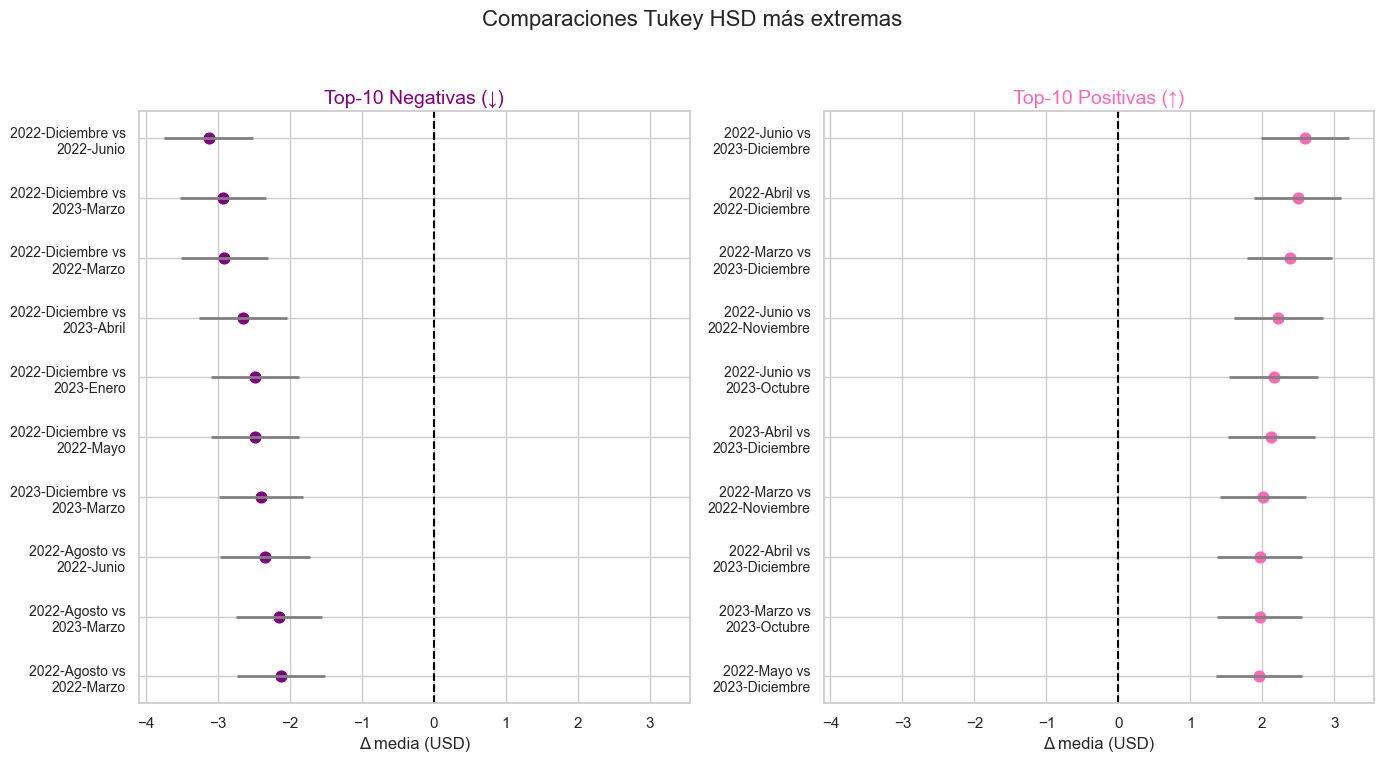

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# — 1) Extraer índices de par y armar el DataFrame —
# tukey es tu TukeyHSDResults
idx1, idx2 = tukey._multicomp.pairindices   # tuple de dos arrays
groups = tukey._multicomp.groupsunique

res = pd.DataFrame({
    "g1":       groups[idx1],
    "g2":       groups[idx2],
    "meandiff": tukey.meandiffs,
    "lower":    tukey.confint[:,0],
    "upper":    tukey.confint[:,1],
    "reject":   tukey.reject
})

# — 2) Filtrar sólo las comparaciones significativas —
sig = res[res["reject"]].copy()
sig["absdiff"] = sig["meandiff"].abs()

# — 3) Tomar top-10 positivas y top-10 negativas —
pos = sig[sig["meandiff"] > 0].nlargest(10, "meandiff").sort_values("meandiff")
neg = sig[sig["meandiff"] < 0].nsmallest(10, "meandiff").sort_values("meandiff", ascending=False)

# función para envolver etiquetas largas
def wrap_lbl(row):
    lbl = f"{row['g1']} vs {row['g2']}"
    return "\n".join(textwrap.wrap(lbl, width=20))

pos["label"] = pos.apply(wrap_lbl, axis=1)
neg["label"] = neg.apply(wrap_lbl, axis=1)

# — 4) Panel de intervalos de confianza —
def panel(df_panel, ax, title, color):
    y = np.arange(len(df_panel))
    for i, row in enumerate(df_panel.itertuples()):
        ax.hlines(i, row.lower, row.upper, color="gray", lw=2)
        ax.scatter(row.meandiff, i, color=color, s=60)
    ax.axvline(0, ls="--", color="black")
    ax.set_yticks(y)
    ax.set_yticklabels(df_panel["label"], fontsize=10)
    ax.set_title(title, color=color)
    ax.set_xlabel("Δ media (USD)")

fig, (axn, axp) = plt.subplots(1, 2, figsize=(14,8), sharex=True)

panel(neg, axn, "Top-10 Negativas (↓)", "#800080")  # morado
panel(pos, axp, "Top-10 Positivas (↑)", "#FF69B4")  # rosa

fig.suptitle("Comparaciones Tukey HSD más extremas", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


In [340]:
# %%
# 10) Mostrar el resumen mensual de forma estilizada
from IPython.display import display

# Preparamos solo las columnas que queremos mostrar
df_resumen = summary_monthly[["año","mes","total","promedio","desviacion"]].copy()

# Aplicamos formato y resaltado
styled = (
    df_resumen
      .style
      .format({
          "total":      "{:,.0f}",
          "promedio":   "{:.2f}",
          "desviacion": "{:.2f}"
      })
      .set_caption("**Resumen Mensual de Ventas (USD)**")
      .highlight_max(subset="total", color="#FFEB3B")
      .background_gradient(subset="promedio", cmap="Purples")
)
display(styled)


,año,mes,total,promedio,desviacion
0,2022,Enero,"1,679,173",13.87,53.07
1,2022,Febrero,"1,745,344",14.59,40.54
2,2022,Marzo,"1,611,731",12.96,35.05
3,2022,Abril,"1,688,750",13.38,39.14
4,2022,Mayo,"1,628,591",13.39,36.56
5,2022,Junio,"1,439,808",12.75,27.84
6,2022,Julio,"1,819,998",14.61,40.40
7,2022,Agosto,"1,806,540",15.09,48.25
8,2022,Septiembre,"1,759,280",13.98,43.07
9,2022,Octubre,"1,774,190",13.85,42.24


C:\Users\maria\AppData\Local\Temp\ipykernel_13780\3841756610.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


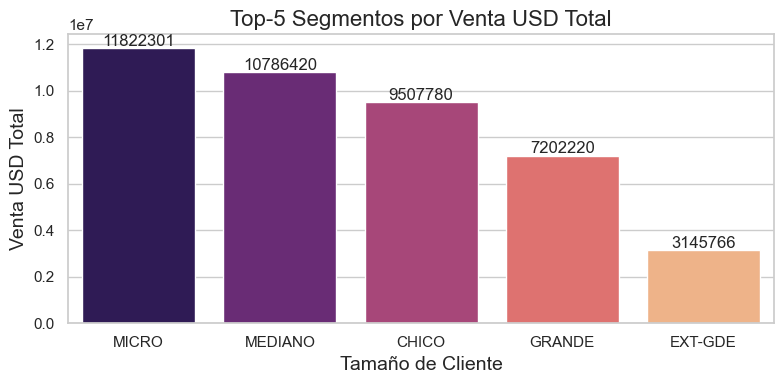

C:\Users\maria\AppData\Local\Temp\ipykernel_13780\3841756610.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


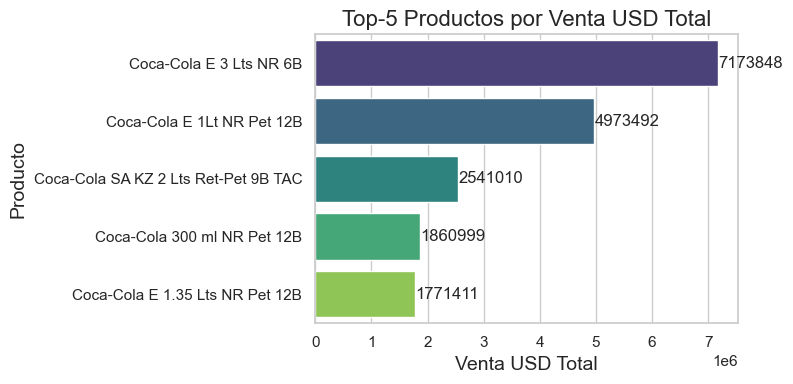

In [341]:
# %%
# 11) Gráficas de segmentos y productos

# — a) Top-5 segmentos por venta total —
seg_sum = (
    df
      .groupby("tamaño_de_cliente")["venta_usd"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .reset_index()
)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(
    data=seg_sum,
    x="tamaño_de_cliente",
    y="venta_usd",
    palette="magma",
    ax=ax
)
ax.set_title("Top-5 Segmentos por Venta USD Total")
ax.set_xlabel("Tamaño de Cliente")
ax.set_ylabel("Venta USD Total")
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 1e5,
            f'{p.get_height():.0f}',
            ha="center")
plt.tight_layout()
plt.show()

# — b) Top-5 productos por venta total —
prod_sum = (
    df
      .groupby("producto")["venta_usd"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .reset_index()
)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(
    data=prod_sum,
    x="venta_usd",
    y="producto",
    palette="viridis",
    ax=ax
)
ax.set_title("Top-5 Productos por Venta USD Total")
ax.set_xlabel("Venta USD Total")
ax.set_ylabel("Producto")
for i, row in prod_sum.iterrows():
    ax.text(row["venta_usd"] + 1e4, i, f'{row["venta_usd"]:.0f}', va="center")
plt.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_13780\3573680256.py:24: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


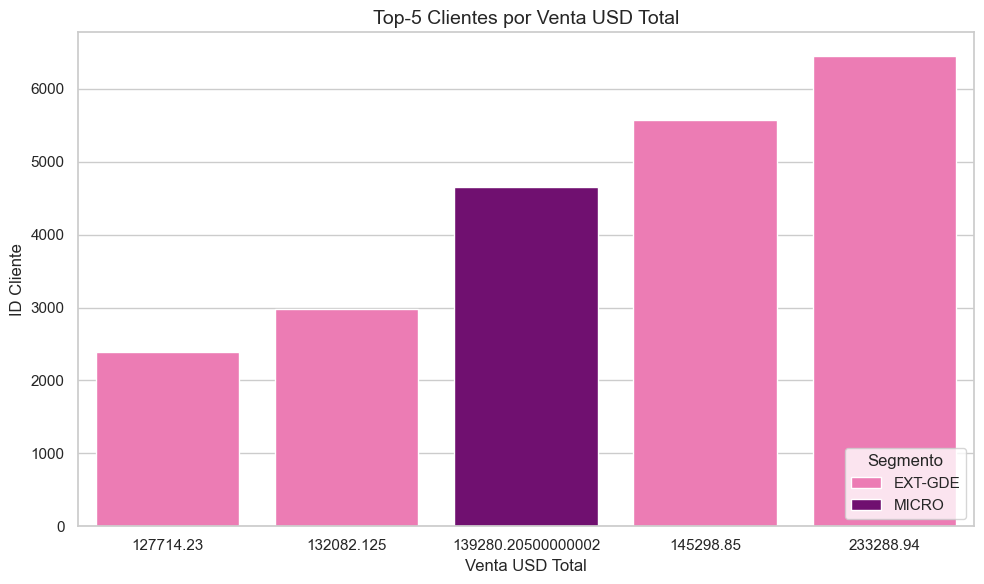

In [349]:
# %%  
# Top-10 Clientes por Venta USD Total
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# Ajusta aquí al nombre real de tu columna de segmento
segmento_col = "tamaño_de_cliente"  

# 1) Agrupar y sumar ventas
top_clients = (
    df
      .groupby(["id_cliente", segmento_col], observed=True)["venta_usd"]
      .sum()
      .reset_index()
)

# 2) Seleccionar Top-5
top10 = top_clients.nlargest(5, "venta_usd")

# 3) Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10,
    x="venta_usd", 
    y="id_cliente",
    hue=segmento_col,
    dodge=False,
    palette=["#FF69B4", "#800080", "#FFC0CB"]
)

# a) Limitar a 5 ticks en X
ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

# b) Formatear para que aparezcan en K (miles)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x/1000):,}K"))

plt.title("Top-5 Clientes por Venta USD Total")
plt.xlabel("Venta USD Total")
plt.ylabel("ID Cliente")
plt.legend(title="Segmento", loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
# %%  
# Dashboard con colores por segmento en Top-10 Clientes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import VBox, HBox, SelectMultiple, Output
from IPython.display import display
from matplotlib.ticker import FuncFormatter

# — Colores por segmento —
segment_palette = {
    "EXT-GDE": "#8C6BB1",
    "GRANDE": "#C49CDE",
    "MICRO": "#D1C4E9",
    "CHICO": "#E1BEE7",
    "MEDIANO": "#FF69B4"
}

COLOR_LINE_22 = "#800080"
COLOR_LINE_23 = "#FF69B4"
COLOR_BAR      = "#FF69B4"

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (6,3),
    "axes.titlesize": 14,
    "axes.labelsize": 12
})

fmt_millones  = FuncFormatter(lambda x, pos: f"{x/1e6:.1f}M")
fmt_miles     = FuncFormatter(lambda x, pos: f"{x/1e3:.0f}K")

# — Renombra si hace falta —
df.rename(columns={"segmento":"tamaño_de_cliente"}, inplace=True)
df["venta_usd"] = pd.to_numeric(df["venta_usd"], errors="coerce")

# — Prepara data de “Top” —
top_clients = (
    df.groupby(["id_cliente","tamaño_de_cliente"], observed=True)["venta_usd"]
      .sum(min_count=1).reset_index()
      .dropna(subset=["venta_usd"])
      .nlargest(10, "venta_usd")
)
top_segs = (
    df.groupby("tamaño_de_cliente", observed=True)["venta_usd"]
      .sum(min_count=1).reset_index()
      .dropna(subset=["venta_usd"])
      .nlargest(5, "venta_usd")
)
top_prods = (
    df.groupby("producto", observed=True)["venta_usd"]
      .sum(min_count=1).reset_index()
      .dropna(subset=["venta_usd"])
      .nlargest(5, "venta_usd")
)

# — Salidas —
out_res  = Output()
out_cli  = Output()
out_seg  = Output()
out_prod = Output()

# A) Ventas mensuales (millones)
with out_res:
    fig, ax = plt.subplots()
    for año, grp in summary_monthly.groupby("año"):
        c = COLOR_LINE_22 if año==2022 else COLOR_LINE_23
        ax.plot(grp["mes"], grp["total"], marker='o', color=c, label=str(año))
    ax.set_xticklabels(summary_monthly["mes"].cat.categories, rotation=45)
    ax.yaxis.set_major_formatter(fmt_millones)
    ax.set_ylabel("USD (millones)")
    ax.set_title("Ventas Mensuales 2022 vs 2023")
    ax.legend(title="Año", frameon=False)
    plt.tight_layout()
    plt.show()

# B) Top-10 Clientes (miles, colores por segmento, con filtro)
seg_selector = SelectMultiple(
    options=sorted(top_clients["tamaño_de_cliente"].unique()),
    value=tuple(top_clients["tamaño_de_cliente"].unique()),
    description='Segmentos',
    layout={'width':'180px'}
)

def actualizar_cli(_=None):
    sel = list(seg_selector.value)
    d = top_clients[top_clients["tamaño_de_cliente"].isin(sel)]
    with out_cli:
        out_cli.clear_output(wait=True)
        fig, ax = plt.subplots()
        # Mapea colores por segmento
        palette = d["tamaño_de_cliente"].map(segment_palette)
        bars = ax.barh(d["id_cliente"].astype(str), d["venta_usd"], color=palette)
        # Leyenda personalizada por segmento (solo los que aparecen)
        handles = [
            plt.Rectangle((0,0),1,1, color=segment_palette[s]) 
            for s in d["tamaño_de_cliente"].unique()
        ]
        labels = d["tamaño_de_cliente"].unique()
        ax.legend(handles, labels, title="Segmento", frameon=False)
        ax.set_xlabel("Venta USD Total")
        ax.set_ylabel("ID Cliente")
        ax.set_title("Top-10 Clientes por Venta USD Total")
        ax.xaxis.set_major_formatter(fmt_miles)
        plt.tight_layout()
        plt.show()

seg_selector.observe(actualizar_cli, names='value')
actualizar_cli()

# C) Top-5 Segmentos (miles)
with out_seg:
    fig, ax = plt.subplots()
    sns.barplot(data=top_segs, x="venta_usd", y="tamaño_de_cliente",
                color=COLOR_LINE_22, ax=ax)
    ax.xaxis.set_major_formatter(fmt_miles)
    ax.set_xlabel("USD (miles)")
    ax.set_title("Top-5 Segmentos por Venta USD")
    for i,(seg,usd) in enumerate(zip(top_segs["tamaño_de_cliente"], top_segs["venta_usd"])):
        ax.text(usd*1.02, i, f"{usd/1e3:.0f}K")
    plt.tight_layout()
    plt.show()

# D) Top-5 Productos (miles)
with out_prod:
    fig, ax = plt.subplots()
    sns.barplot(data=top_prods, x="venta_usd", y="producto",
                color=COLOR_LINE_23, ax=ax)
    ax.xaxis.set_major_formatter(fmt_miles)
    ax.set_xlabel("USD (miles)")
    ax.set_title("Top-5 Productos por Venta USD")
    for i,(prod,usd) in enumerate(zip(top_prods["producto"], top_prods["venta_usd"])):
        ax.text(usd*1.02, i, f"{usd/1e3:.0f}K")
    plt.tight_layout()
    plt.show()

# — Ensamblar dashboard —
dashboard = VBox([
    out_res,
    HBox([seg_selector, out_cli], layout={'align_items':'flex-start'}),
    out_seg,
    out_prod
])
display(dashboard)

          Modelo     RMSE (CV)   RMSE (Test)  R² (Test)
Regresión Lineal 185097.528248 101451.484343   0.039193
   Random Forest 128999.139922 142336.880301  -0.891273

Modelo elegido: Regresión Lineal
            real      predicho
8   1759279.695  1.801846e+06
16  1837143.810  1.696982e+06
0   1679173.470  1.546529e+06
18  1777155.435  1.888388e+06
11  1989083.505  1.995183e+06


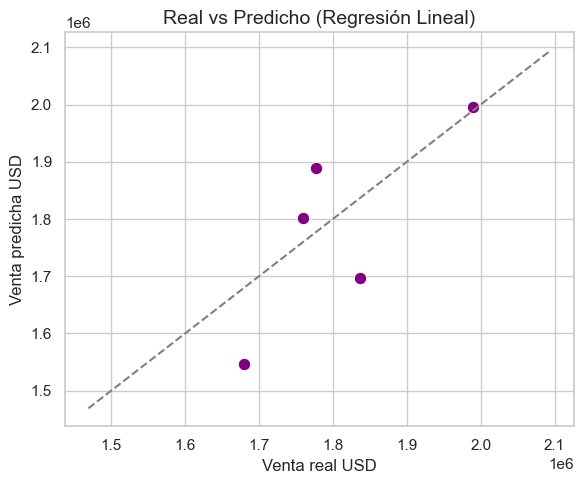

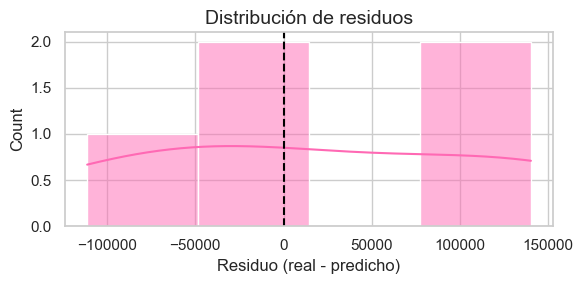

In [344]:
# %%  
# 9) Evaluación visual y tabla de resultados
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepara X, y (igual que antes) ---
df_model = summary_monthly.copy()
df_model["año_num"]  = df_model["año"].astype(int)
df_model["mes_no"]   = df_model["mes_no"].astype(int)
df_model["mes_acum"] = (df_model["año_num"] - 2022)*12 + df_model["mes_no"]
mes_dummies = pd.get_dummies(df_model["mes_no"], prefix="mes", drop_first=True)
X = pd.concat([df_model[["mes_acum"]], mes_dummies], axis=1)
y = df_model["total"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelos
models = {
    "Regresión Lineal": LinearRegression(),
    "Random Forest":    RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []
predictions = {}

for name, model in models.items():
    # CV-RMSE
    cv = cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error", cv=5
    )
    rmse_cv = -cv.mean()
    # Fit & predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    # Test metrics
    rmse_test = root_mean_squared_error(y_test, y_pred)
    r2_test   = r2_score(y_test, y_pred)
    results.append({
        "Modelo":     name,
        "RMSE (CV)":  rmse_cv,
        "RMSE (Test)":rmse_test,
        "R² (Test)":  r2_test
    })

# — Tabla de métricas —
df_res = pd.DataFrame(results)
print(df_res.to_string(index=False))

# — DataFrame real vs predicho (para el mejor modelo) —
mejor = df_res.sort_values("RMSE (Test)").iloc[0]["Modelo"]
df_comp = pd.DataFrame({
    "real": y_test.values,
    "predicho": predictions[mejor]
}, index=y_test.index)
print(f"\nModelo elegido: {mejor}\n", df_comp)

# — Gráfica real vs predicho —
plt.figure(figsize=(6,5))
sns.scatterplot(x="real", y="predicho", data=df_comp, s=80, color="#800080")
lims = [df_comp.values.min()*0.95, df_comp.values.max()*1.05]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Venta real USD")
plt.ylabel("Venta predicha USD")
plt.title(f"Real vs Predicho ({mejor})")
plt.tight_layout()
plt.show()

# — Histograma de residuos —
residuos = df_comp["real"] - df_comp["predicho"]
plt.figure(figsize=(6,3))
sns.histplot(residuos, kde=True, color="#FF69B4")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Residuo (real - predicho)")
plt.title("Distribución de residuos")
plt.tight_layout()
plt.show()
